#🔹 1. Importing Libraries

In [19]:
import re
import pickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


In [20]:
df = pd.read_csv("/content/Egypt_Tourism_Sentiment_Analysis.csv")

In [21]:
df

,review,processed_review,sentiment_ensemble
0,Well worth going to visit. If you are getting ...,well worth going visit getting tour fantastic ...,positive
1,The splendor of the pyramidsThe Seven Wonders ...,splendor pyramidsthe seven wonder world seen p...,positive
2,The pyramids are among the most beautiful arch...,pyramid among beautiful archaeological site wo...,positive
3,"yes it crowded, yes there is some tourist trap...",yes crowded yes tourist trap yes queue frustra...,positive
4,"History & Mystery of The Pyramids, What a Day,...",history mystery pyramid day hit visit land leg...,positive
...,...,...,...
38390,"The view is absolutely worth it. However, the ...",view absolutely worth however people around pu...,positive
38391,The Cairo tower is an essential part of the Ca...,cairo tower essential part cairo skyline talle...,positive
38392,One of the things that disturbs me is the dual...,one thing disturbs dual pricing system place l...,positive
38393,Our tour guides from GAT Tours also pointed ou...,tour guide gat tour also pointed u cairo tower...,positive


In [22]:
df.isna().sum()

,0
review,0
processed_review,0
sentiment_ensemble,1


In [23]:
df.dropna(inplace=True)

In [24]:
df.duplicated().sum()

np.int64(34)

In [25]:
df.drop_duplicates(inplace=True)

In [26]:
df.columns

Index(['review', 'processed_review', 'sentiment_ensemble'], dtype='object')

In [27]:
df['sentiment_ensemble'] = df['sentiment_ensemble'].replace('non_positive', 'negative')
# df['sentiment_ensemble'] = df['sentiment_ensemble'].replace('neutral', 'negative')

In [28]:
df.sentiment_ensemble.value_counts()

,count
sentiment_ensemble,
positive,34170
negative,4190


<ipython-input-29-7c4f04fc5fa2>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment_ensemble', palette='bright')


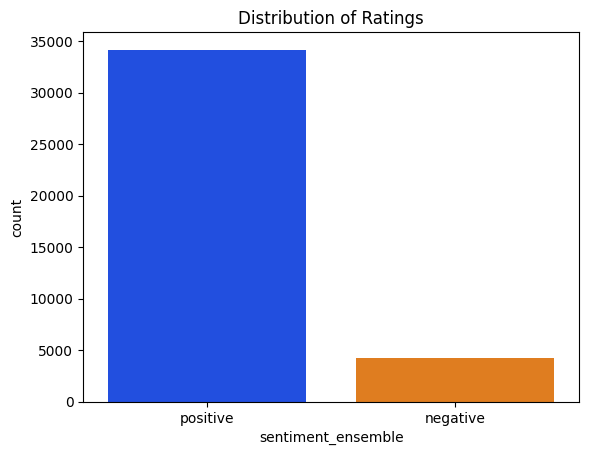

In [29]:
sns.countplot(data=df, x='sentiment_ensemble', palette='bright')
plt.title('Distribution of Ratings')
plt.show()


# Handling class imbalance by Upsamling data

In [30]:
X = df['processed_review']
y = df['sentiment_ensemble']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train_df = pd.DataFrame({'processed_review': X_train, 'sentiment_ensemble': y_train})
test_df = pd.DataFrame({'processed_review': X_test, 'sentiment_ensemble': y_test})


In [31]:
from sklearn.utils import resample

df_majority = train_df[train_df.sentiment_ensemble == 'positive']
df_minority = train_df[train_df.sentiment_ensemble != 'positive']

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

train_upsampled = pd.concat([df_majority, df_minority_upsampled])


In [32]:
X_train_balanced = train_upsampled['processed_review']
y_train_balanced = train_upsampled['sentiment_ensemble']

X_test = test_df['processed_review']
y_test = test_df['sentiment_ensemble']


In [33]:
# convert y to data frame to get value count
y_df = pd.DataFrame(y_train_balanced)
y_df.value_counts()

,count
sentiment_ensemble,
negative,27336
positive,27336


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_balanced)
X_test_tfidf = vectorizer.transform(X_test)


In [36]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_balanced)
y_test_encoded = le.transform(y_test)


## Logistic Regression

Accuracy: 0.8726538060479666
              precision    recall  f1-score   support

           0       0.45      0.81      0.58       838
           1       0.97      0.88      0.92      6834

    accuracy                           0.87      7672
   macro avg       0.71      0.84      0.75      7672
weighted avg       0.92      0.87      0.89      7672



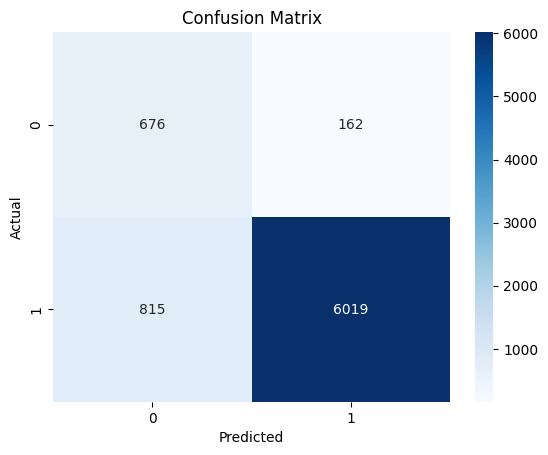

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Model
LR_model = LogisticRegression(max_iter=1000, class_weight='balanced')
LR_model.fit(X_train_tfidf, y_train_encoded)

# Predict
y_pred = LR_model.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print(classification_report(y_test_encoded, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_encoded, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Check if the model is overfitting

In [38]:
from sklearn.metrics import accuracy_score

y_train_pred = LR_model.predict(X_train_tfidf)
train_acc = accuracy_score(y_train_encoded, y_train_pred)
print("Train Accuracy:", train_acc)

test_acc = accuracy_score(y_test_encoded, y_pred)
print("Test Accuracy:", test_acc)



Train Accuracy: 0.9280618964003512
Test Accuracy: 0.8726538060479666


In [39]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(LR_model, X_train_tfidf, y_train_encoded, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


Cross-validation scores: [0.91147691 0.90983082 0.91101152 0.91101152 0.90378635]
Mean CV Accuracy: 0.9094234258692614


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
Valu

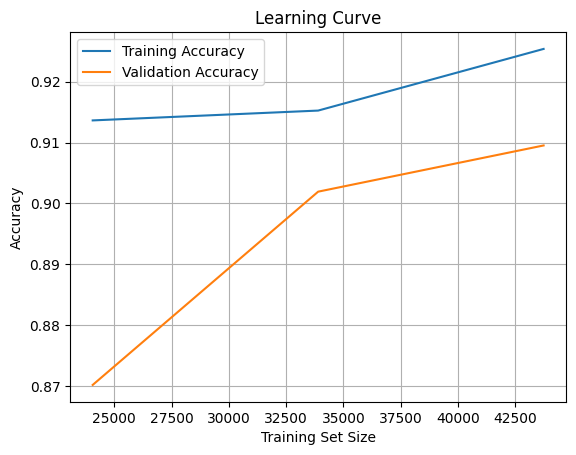

In [42]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    LR_model, X_train_tfidf, y_train_encoded, cv=5, scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, val_mean, label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show();


## Gradient Booting Models

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 27336, number of negative: 27336
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.848004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256170
[LightGBM] [Info] Number of data points in the train set: 54672, number of used features: 4961
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Accuracy: 0.8687434827945777

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.79      0.57       838
           1       0.97      0.88      0.92      6834

    accuracy                           0.87      7672
   macro avg       0.71      0.83      0.75      7672
weighted avg       0.91      0.87      0.88      7672



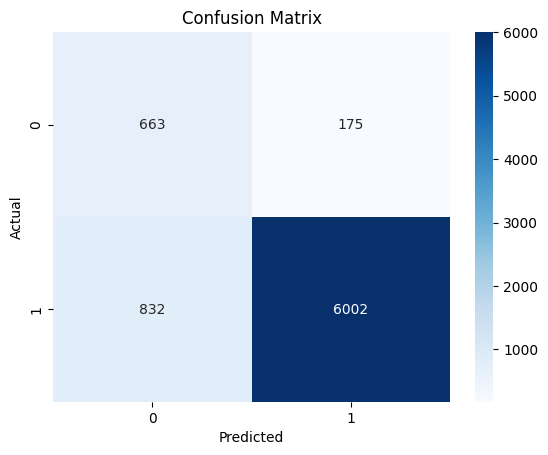

In [43]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train_tfidf, y_train_encoded)

y_pred_lgb = lgb_model.predict(X_test_tfidf)

print("LightGBM Accuracy:", accuracy_score(y_test_encoded, y_pred_lgb))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_lgb))


# Confusion matrix
sns.heatmap(confusion_matrix(y_test_encoded, y_pred_lgb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

XGBoost Accuracy: 0.8704379562043796

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.69      0.54       838
           1       0.96      0.89      0.92      6834

    accuracy                           0.87      7672
   macro avg       0.70      0.79      0.73      7672
weighted avg       0.90      0.87      0.88      7672



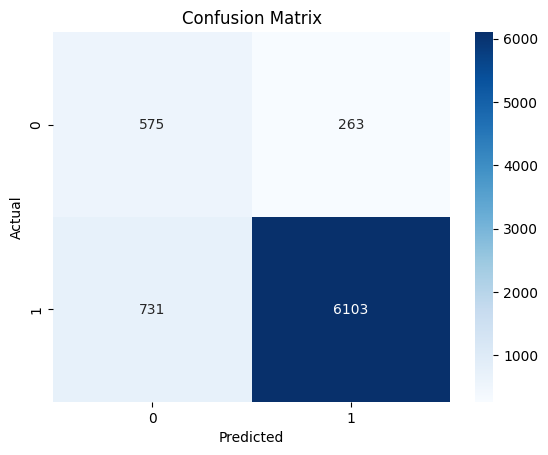

In [44]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_tfidf, y_train_encoded)

y_pred_xgb = xgb_model.predict(X_test_tfidf)

print("XGBoost Accuracy:", accuracy_score(y_test_encoded, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_xgb))

sns.heatmap(confusion_matrix(y_test_encoded, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## SVM

SVM Accuracy: 0.882429614181439

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.74      0.58       838
           1       0.97      0.90      0.93      6834

    accuracy                           0.88      7672
   macro avg       0.72      0.82      0.75      7672
weighted avg       0.91      0.88      0.89      7672



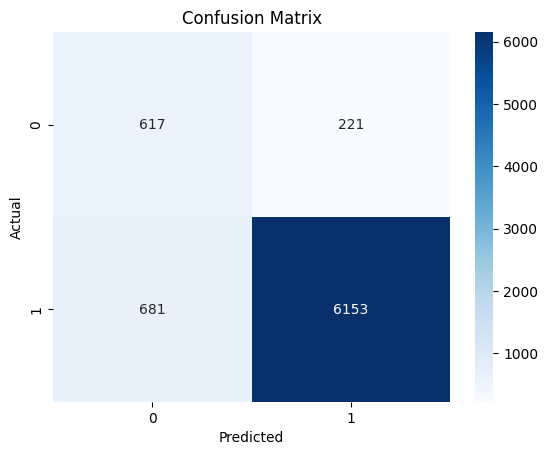

In [45]:
svm_model = LinearSVC(max_iter=2000, random_state=42)
svm_model.fit(X_train_tfidf, y_train_encoded)
y_pred_svm = svm_model.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test_encoded, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_svm))

sns.heatmap(confusion_matrix(y_test_encoded, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Stochastic Gradient Descent (SGD) Classifier

SGD Accuracy: 0.8726538060479666

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.55      0.48       838
           1       0.94      0.91      0.93      6834

    accuracy                           0.87      7672
   macro avg       0.69      0.73      0.71      7672
weighted avg       0.89      0.87      0.88      7672



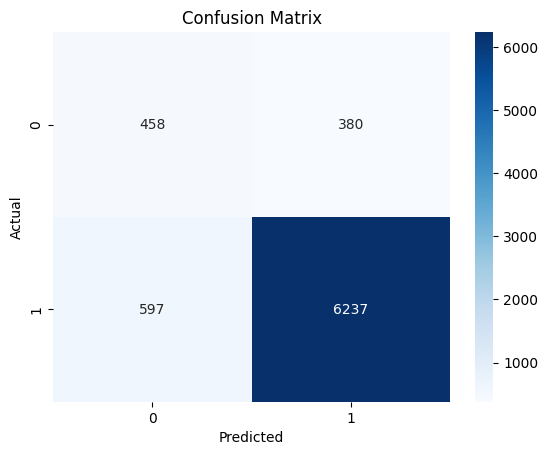

In [47]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


sgd_model = make_pipeline(StandardScaler(with_mean=False), SGDClassifier(loss='hinge',class_weight='balanced', max_iter=1000, random_state=42))
sgd_model.fit(X_train_tfidf, y_train_encoded)

y_pred_sgd = sgd_model.predict(X_test_tfidf)
print("SGD Accuracy:", accuracy_score(y_test_encoded, y_pred_sgd))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_sgd))

sns.heatmap(confusion_matrix(y_test_encoded, y_pred_sgd), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Random Forest

RF Accuracy: 0.911235662148071

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.26      0.39       838
           1       0.92      0.99      0.95      6834

    accuracy                           0.91      7672
   macro avg       0.85      0.63      0.67      7672
weighted avg       0.90      0.91      0.89      7672



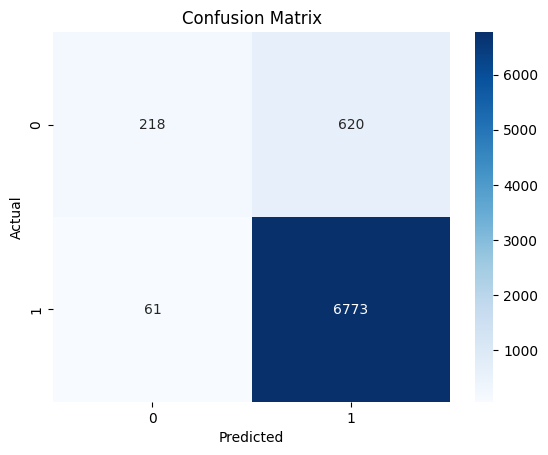

In [73]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(class_weight='balanced', random_state=42)
RF_model.fit(X_train_tfidf, y_train_encoded)
y_pred_RF = RF_model.predict(X_test_tfidf)
print("RF Accuracy:", accuracy_score(y_test_encoded, y_pred_RF))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_RF))

sns.heatmap(confusion_matrix(y_test_encoded,y_pred_RF), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## LSTM

In [75]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional


In [76]:

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_upsampled['processed_review'])

# Convert to sequences
train_sequences = tokenizer.texts_to_sequences(train_upsampled['processed_review'])
test_sequences = tokenizer.texts_to_sequences(test_df['processed_review'])

# Pad sequences
X_train_padded = pad_sequences(train_sequences, maxlen=200, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=200, padding='post', truncating='post')



In [77]:

# LSTM Model
model_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=200),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [78]:

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model_lstm.fit(X_train_padded, y_train_encoded, epochs=3, validation_split=0.1, batch_size=64)


Epoch 1/3
769/769 ━━━━━━━━━━━━━━━━━━━━ 513s 657ms/step - accuracy: 0.8092 - loss: 0.3928 - val_accuracy: 0.9612 - val_loss: 0.1531
Epoch 2/3
769/769 ━━━━━━━━━━━━━━━━━━━━ 501s 652ms/step - accuracy: 0.9660 - loss: 0.1036 - val_accuracy: 0.9764 - val_loss: 0.0838
Epoch 3/3
769/769 ━━━━━━━━━━━━━━━━━━━━ 501s 651ms/step - accuracy: 0.9845 - loss: 0.0490 - val_accuracy: 0.9850 - val_loss: 0.0554


240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step

Classification Report:
               precision    recall  f1-score   support

    negative       0.57      0.45      0.51       838
    positive       0.93      0.96      0.95      6834

    accuracy                           0.90      7672
   macro avg       0.75      0.71      0.73      7672
weighted avg       0.90      0.90      0.90      7672



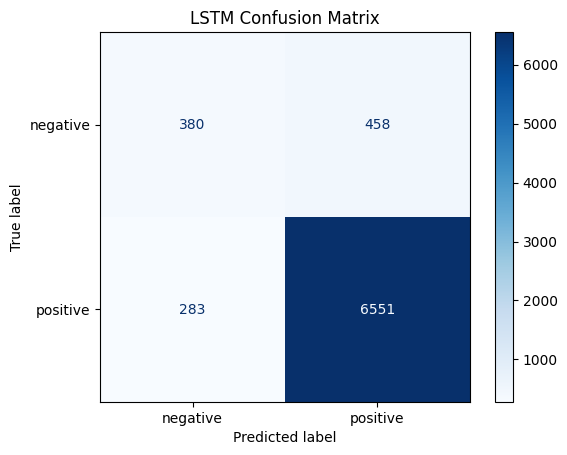

In [79]:
from sklearn.metrics import ConfusionMatrixDisplay

# Predict on test set
y_pred_probs = model_lstm.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Evaluation
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_classes,target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("LSTM Confusion Matrix")
plt.show()


In [80]:

# Predict on sample reviews
test_reviews = [
    "I absolutely loved my trip to Egypt, the pyramids were breathtaking!",
    "It was dirty, crowded, and overpriced — very disappointing.",
    "The tour guide was okay, but the rest was just bad and I didn't like the weather."
]

test_seq = tokenizer.texts_to_sequences(test_reviews)
test_pad = pad_sequences(test_seq, maxlen=200, padding='post', truncating='post')
test_preds = model_lstm.predict(test_pad)
test_labels = le.inverse_transform(np.argmax(test_preds, axis=1))

for review, label in zip(test_reviews, test_labels):
    print(f"Review: {review}\nPredicted Sentiment: {label}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Review: I absolutely loved my trip to Egypt, the pyramids were breathtaking!
Predicted Sentiment: positive

Review: It was dirty, crowded, and overpriced — very disappointing.
Predicted Sentiment: negative

Review: The tour guide was okay, but the rest was just bad and I didn't like the weather.
Predicted Sentiment: negative



## GRU

In [81]:
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional

model_gru = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=200),
    Bidirectional(GRU(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(GRU(32)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model_gru.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_gru.fit(X_train_padded, y_train_encoded, epochs=3, validation_split=0.1, batch_size=64)

y_pred = model_gru.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test_encoded, y_pred_classes, target_names=le.classes_))

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


769/769 ━━━━━━━━━━━━━━━━━━━━ 567s 726ms/step - accuracy: 0.7863 - loss: 0.4309 - val_accuracy: 0.9713 - val_loss: 0.1058
Epoch 2/3
769/769 ━━━━━━━━━━━━━━━━━━━━ 562s 726ms/step - accuracy: 0.9640 - loss: 0.1105 - val_accuracy: 0.9738 - val_loss: 0.1022
Epoch 3/3
769/769 ━━━━━━━━━━━━━━━━━━━━ 569s 739ms/step - accuracy: 0.9828 - loss: 0.0530 - val_accuracy: 0.9945 - val_loss: 0.0237
240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step
              precision    recall  f1-score   support

    negative       0.55      0.53      0.54       838
    positive       0.94      0.95      0.95      6834

    accuracy                           0.90      7672
   macro avg       0.75      0.74      0.74      7672
weighted avg       0.90      0.90      0.90      7672



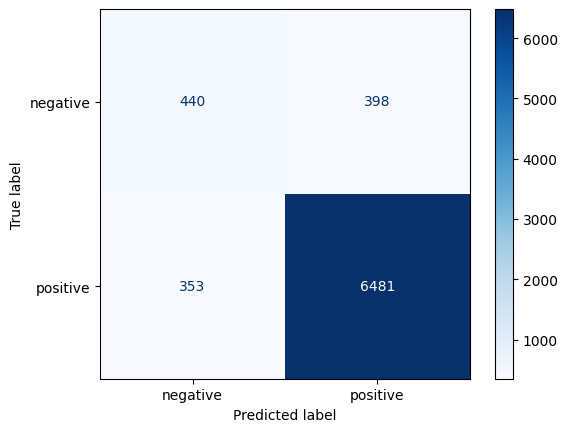

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_encoded, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.show()


### Save ML Models

In [83]:
import pickle


In [84]:
# Save Logistic Regression
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(LR_model, file)

# Save SVM
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)

# Save XGBoost
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

# Save LightGBM
with open('lightgbm_model.pkl', 'wb') as file:
    pickle.dump(lgb_model, file)

# Save Random Forest
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(RF_model, file)  # replace 'model' if RF used another variable


### Save Deep Learning Models (LSTM & GRU)

In [85]:
# Save LSTM
model_lstm.save("lstm_model.h5")
model_gru.save("gru_model.h5")


In [87]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
